# グラフ生成
###目次
- グラフ生成
- Deep Generative Models of Graphs (DGMG)
- 前準備
- データセット (MiniGCDataset)
- DGMG実装
- 学習&評価
- 可視化

# グラフ生成

---



グラフ生成とは,その名の通りグラフを生成する分野です.  
最も一般的なタスクは, 分子構造の生成です.  
分子の性質（水溶性,毒性...）を考慮しながら,分子を生成することで, 創薬研究に役立ちます.

分子構造を考慮できるGCNの発展に伴い,グラフ生成分野も研究が進みました.  
グラフ生成にも色々なアプローチがありますが,ここではDGMGという手法について紹介します.  
画像生成では出来ない,グラフ特有の生成の仕方なので面白いかと思います.

#Deep Generative Models of Graphs (DGMG) [[arXiv](https://arxiv.org/pdf/1803.03324.pdf)]

---



DGMGは3つの識別器と生成フローを組み合わせることでグラフを生成する手法です.  

3つの識別器
- add node：新しいノードを追加　or 追加しない (生成フロー終了)
- add edge：新しいノードにエッジを追加 or 追加しない
- choose dest：新しいノードと，どのノードにエッジを追加するのかの確率

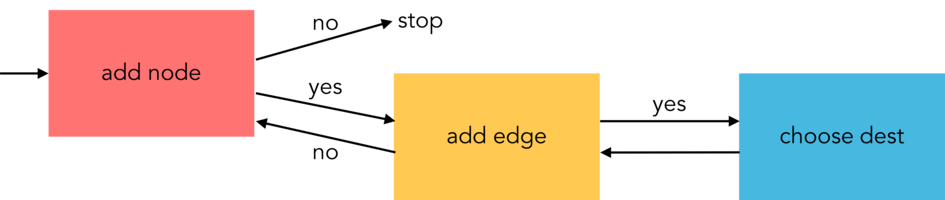

3つのノードをもつグラフの生成過程の例が下の画像です.  
生成フローと照らし合わせながら見ると分かりやすいと思います.  

ここで，各識別器の出力を並べると``[0100010000111]``のようなシーケンスとして表現することが出来ます.DGMGはこれを教師として学習を行います.  
DGMGはグラフの形そのものを学習するのではなく, そのグラフにたどり着くための識別器の出力順を学習します.

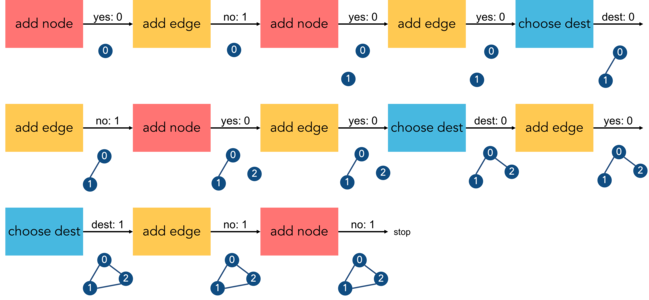

# 前準備

必要なモジュールをインストール, インポートします.

In [ ]:
pip install dgl  \
pip install networkx

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Bernoulli
import dgl
from dgl.data import MiniGCDataset
import networkx as nx
import matplotlib.pyplot as plt

GPU確認

In [ ]:
print('Use CUDA:', torch.cuda.is_available())

# データセット　(MiniGCDataset)

---



生成される化合物を直感的に評価することが難しいので,ここでは簡単なグラフ構造の生成を試みます.  
DGLが提供する, MiniGCDatasetを利用します.  
MiniGCDatasetは, 8クラスのグラフ構造を持ち, クラスごとにノード数が異なるグラフを持ちます.

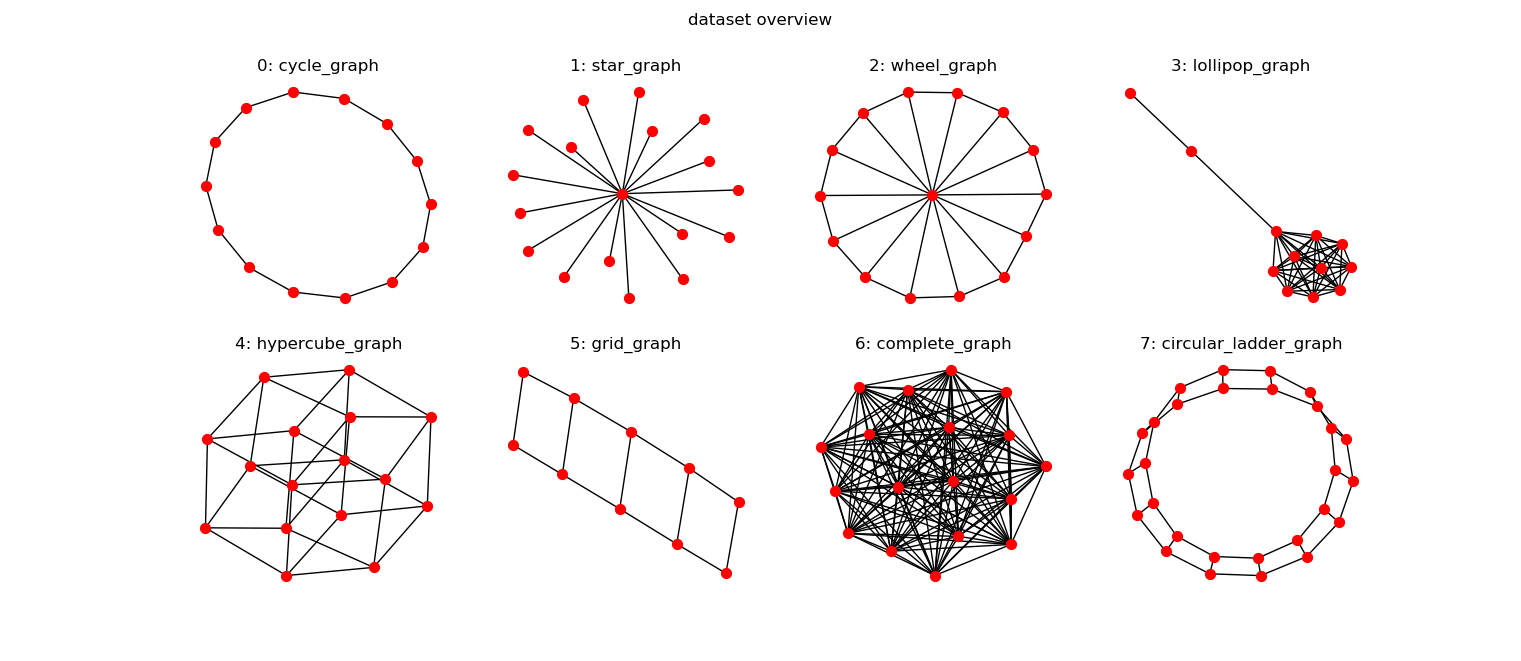
引用元[https://www.dgl.ai/blog/2019/01/25/batch.html]

MiniGCDatasetはデータセットではあるものの，データ数や，ノード数を自由に設定できます.

In [ ]:
num_per_graph = 100 # クラスごとのデータ数
min_num_node = 10 # 生成されるグラフの最小ノード数
max_num_node = 20 # 生成されるグラフの最大ノード数
dataset = MiniGCDataset(num_per_graph*8, min_num_node, max_num_node)

データを可視化してみます.データはクラスごとに並んでいます.  
クラスごとのデータ数を100にした場合, 0\~99がクラス0, 100\~199がクラス1　のようになっています.  
``DATA_INDEX``を編集して，可視化してみてください.  
最小，最大ノード数内のノード数のグラフが生成されています.

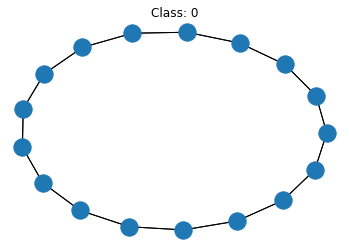

In [ ]:
DATA_INDEX = 10

graph, label = dataset[DATA_INDEX]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax, arrows=False)
ax.set_title('Class: {:d}'.format(label))
plt.show()

# DGMG実装

---



### graph embedding

In [ ]:
class GraphEmbed(nn.Module):
    def __init__(self, node_hidden_size, gpu):
        super(GraphEmbed, self).__init__()
        self.gpu = gpu
        self.graph_hidden_size = 2 * node_hidden_size
        # graph embed
        self.node_gating = nn.Sequential(
            nn.Linear(node_hidden_size, 1),
            nn.Sigmoid()
        )
        self.node_to_graph = nn.Linear(node_hidden_size,
                                       self.graph_hidden_size)

    def forward(self, g):
        if g.number_of_nodes() == 0:
            return torch.zeros(1, self.graph_hidden_size).to(self.gpu)
        else:
            hvs = g.ndata['hv']
            hvs = (self.node_gating(hvs) * self.node_to_graph(hvs)).sum(0, keepdim=True)
            return hvs


### graph_prop

In [ ]:
class GraphProp(nn.Module):
    def __init__(self, num_hidden_size, num_prop_rounds):
        super(GraphProp, self).__init__()
        self.gc1 = GraphConv(num_hidden_size, 2 * num_hidden_size)
        self.gc2 = GraphConv(2 * num_hidden_size, num_hidden_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g):
        if g.number_of_edges() == 0:
            return g
        else:
            h = self.gc1(g, g.ndata['hv'])
            h = self.sigmoid(h)
            g.ndata['hv'] = self.gc2(g, h)
            return g


### add node

In [ ]:
def bernoulli_action_prob(logit, action):
    """Calculate the log p of an action with respect to a Bernoulli
    distribution. Use logit rather than prob for numerical stability."""
    if action == 0:
        return F.logsigmoid(-logit)
    else:
        return F.logsigmoid(logit)

class AddNode(nn.Module):
    def __init__(self, graph_embed, node_hidden_size, gpu):
        super(AddNode, self).__init__()
        self.gpu = gpu
        self.graph_embed = graph_embed
        self.add_node = nn.Linear(graph_embed.graph_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        # initialize node
        self.node_embed = nn.Embedding(1, node_hidden_size)
        self.initialize_hv = nn.Linear(graph_embed.graph_hidden_size, node_hidden_size)
        self.activation_node = torch.zeros(1, 2 * node_hidden_size).to(gpu)

    def prepare_training(self):
        self.log_prob = 0

    def initialize_node(self, g, graph_feature):
        last_node = g.number_of_nodes() - 1
        hv_init = self.initialize_hv(graph_feature)
        g.nodes[last_node].data['hv'] = hv_init
        g.nodes[last_node].data['a'] = self.activation_node
        return g

    def forward(self, g, action=None):
        graph_feature = self.graph_embed(g)
        logit = self.add_node(graph_feature)

        if self.training:
            self.log_prob += bernoulli_action_prob(logit, action)
        else:
            prob = self.sigmoid(logit)
            action = Bernoulli(prob).sample().item()

        stop = bool(action == 1)  # 1 is stop

        if not stop:
            g.add_nodes(1)
            g = self.initialize_node(g, graph_feature)

        return g, stop


### add edge

In [ ]:
class AddEdge(nn.Module):
    def __init__(self):
        super(AddEdge, self).__init__()
        self.graph_embed = graph_embed
        self.add_edge = nn.Linear(graph_embed.graph_hidden_size + node_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, action=None):
        graph_feature = self.graph_embed(g)
        last_node_feature = g.nodes[g.number_of_nodes() - 1].data['hv']
        logit = self.add_edge(
            torch.cat([
                graph_feature,
                last_node_feature
            ], dim=1))

        if self.training:
            self.log_prob += bernoulli_action_prob(logit, action)
        else:
            prob = self.sigmoid(logit)
            action = Bernoulli(prob).sample().item()

        to_add_edge = bool(action == 0)

        return to_add_edge

### choose dest

In [ ]:
class ChooseDest(nn.Module):
    def __init__(self, graph_prop, node_hidden_size, gpu):
        super(ChooseDest, self).__init__()
        self.gpu = gpu
        self.graph_prop = graph_prop
        self.choose_dest = nn.Linear(2 * node_hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

    def prepare_training(self):
        self.log_prob = 0

    def initialize_edge(self, g, src_list, dest_list):
        edge_repr = torch.ones(len(src_list), 1).to(self.gpu)
        g.edges[src_list, dest_list].data['he'] = edge_repr
        return g

    def initialize_edge_loop(self, g, src_list):
        edge_repr = torch.ones(1, 1).to(self.gpu)
        g.edges[src_list[0], src_list[1]].data['he'] = edge_repr
        return g

    def forward(self, g, dest=None):
        num_node = g.number_of_nodes()
        last_node = num_node - 1
        possible_dest = range(num_node)
        last_node_feature_expand = g.nodes[last_node].data['hv'].expand(num_node, -1)
        possible_dest_feature = g.nodes[possible_dest].data['hv']
        dests_scores = self.choose_dest(
            torch.cat([
                possible_dest_feature,
                last_node_feature_expand
            ], dim=1)).view(1, -1)
        dests_probs = self.softmax(dests_scores)

        if self.training:
            dest = int(dest.item())
            if dests_probs.nelement() > 1:
                self.log_prob += F.log_softmax(dests_scores, dim=1)[:, dest: dest+1]
        else:
            dest = Categorical(dests_probs).sample().item()

        if not g.has_edge_between(last_node, dest):
            src_list = [last_node, dest]
            if last_node != dest:
                dest_list = [dest, last_node]
                g.add_edges(src_list, dest_list)
                g = self.initialize_edge(g, src_list, dest_list)
            else:
                dest_list = None
                g.add_edges(last_node, dest)
                g = self.initialize_edge_loop(g, src_list)
            g = self.graph_prop(g)
        return g


### DGMG

In [ ]:
class DGMG(nn.Module):
    def __init__(self):
        super(DGMG, self).__init__()
        self.max_num_node = max_num_node
        self.gpu = gpu
        self.graph_embed = GraphEmbed(node_hidden_size, gpu)
        self.graph_prop = GraphProp(node_hidden_size,num_prop_rounds=2)
        self.add_node = AddNode(self.graph_embed, node_hidden_size, gpu)
        self.add_edge = AddEdge(self.graph_embed, node_hidden_size)
        self.choose_dest = ChooseDest(self.graph_prop, node_hidden_size, gpu)
        self.init_weights()

    def init_weight(self):
        self.graph_embed.apply(weights_init)
        self.graph_prop.apply(weights_init)
        self.add_node.apply(weights_init)
        self.add_edge.apply(weights_init)
        self.choose_dest.apply(weights_init)

    @property
    def action_step(self)
        last_step_count = self.step_count
        self.step_count += 1
        return last_step_count

    def prepare_for_train(self):
        self.step_count = 0
        self.add_node.prepare_training()
        self.add_edge.prepare_training()
        self.choose_dest.prepare_training()

    def get_log_prob(self):
        return self.add_node.log_prob + self.add_edge.log_prob + self.choose_dest.log_prob

    def forward_train(self, sequence):
        self.prepare_for_train()
        self.g, stop = self.add_node(self.g, sequence[self.action_step])
        while not stop:
            to_add_edge = self.add_edge(self.g, sequence[self.action_step])
            while to_add_edge:
                self.g = self.choose_dest(self.g, sequence[self.action_step])
                to_add_edge = self.add_edge(self.g, sequence[self.action_step])
            self.g, stop = self.add_node(self.g, sequence[self.action_step])
        return self.get_log_prob()

    def forward_eval(self):
        self.g, stop = self.add_node(self.g)
        while (not stop) and (self.g.number_of_nodes() < self.max_num_node + 1):
            num_dest = 0
            to_add_edge = self.add_edge(self.g)
            while to_add_edge and (num_dest < self.g.number_of_nodes() - 1):
                self.g = self.choose_dest(self.g)
                num_dest += 1
                to_add_edge = self.add_edge(self.g)
            self.g, stop = self.add_node(self.g)
        return self.g

    def forward(self, sequence=None):
        self.g = dgl.DGLGraph()
        self.g.set_n_initializer(dgl.frame.zero_initializer)
        self.g.set_e_initializer(dgl.frame.zero_initializer)
        if self.training:
            return self.forward_train(sequence)
        else:
            return self.forward_eval()  

# 学習&評価

---



# 可視化

---

